# Neuropathology Visium Analysis
## Analysis of Cerebellar Layer Measurements Sorted by Gestational Age

This notebook analyzes measurements from different cerebellar layers (ML, IGL, EGL, WM) 
and creates heatmaps sorted by gestational age (GA).

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Load and Initial Data Exploration

In [2]:
# Define file path - update this to your actual file location
csv_file_path = '/Users/rvidva/Library/CloudStorage/OneDrive-ChildrensNationalHospital/co-workspace/neuropath_visium/measurements.csv'

# Load the data
print("Loading data from CSV file...")
df = pd.read_csv(csv_file_path)

# Display basic information about the dataset
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
df.head()

Loading data from CSV file...

Dataset shape: (75, 11)
Columns: ['Image', 'Object ID', 'Object type', 'Name', 'Classification', 'Parent', 'ROI', 'Centroid X µm', 'Centroid Y µm', 'Area µm^2', 'Perimeter µm']

First few rows:


,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Area µm^2,Perimeter µm
0,1055A.tif - BF.ome.tif,3406140d-289a-4183-9c60-4b2bb3c46a4c,Annotation,4.0,WM,Root object (Image),Geometry,5575.6,5120.3,1009275.1,19417.1
1,1055A.tif - BF.ome.tif,7a6de77b-e1b3-49e9-aefd-00501e43ab69,Annotation,1.0,EGL,Root object (Image),Geometry,5002.9,5067.5,752911.5,63362.4
2,1055A.tif - BF.ome.tif,db96d5d0-a937-44fd-ad6c-12612a1cde6d,Annotation,3.0,ML,Root object (Image),Geometry,4726.3,4520.2,7956042.7,97074.1
3,1055A.tif - BF.ome.tif,ea3a6a5b-c59d-4b72-b6b8-4ac708b48167,Annotation,2.0,IGL,Root object (Image),Geometry,5044.4,4038.4,10152471.3,75625.2
4,1055A.tif - BF.ome.tif,d45c7934-8bf0-427a-b1b3-e5c21ba4b26f,Annotation,3.0,ML_IGL_150uM,Root object (Image),Geometry,5077.3,4261.5,4460116.7,62817.0


## 3. Data Preprocessing
### 3.1 Extract Sample ID and Image Letter from Image Column

In [3]:
# Extract sample information from the Image column
print("Extracting sample ID and image letter from Image column...")

# Step 1: Keep only the part before the first period
# Example: '1055A.tif-BF.ome.tif' -> '1055A'
df['temp'] = df['Image'].str.split('.', n=1).str[0]

# Step 2: Split into numeric (ID) and letter (Image) parts
# Example: '1055A' -> ID='1055', Image='A'
df['ID'] = df['temp'].str.extract('(\d+)', expand=False)  # Extract numbers
df['Image_Letter'] = df['temp'].str.extract('([A-Za-z]+)', expand=False)  # Extract letters

# Create Sample column by combining ID and Image_Letter
df['Sample'] = df['ID'] + df['Image_Letter']

# Drop the temporary column
df = df.drop('temp', axis=1)

# Display the results
print("\nSample ID and Image extraction complete:")
print(df[['Image', 'ID', 'Image_Letter', 'Sample']].head())

Extracting sample ID and image letter from Image column...

Sample ID and Image extraction complete:
                    Image    ID Image_Letter Sample
0  1055A.tif - BF.ome.tif  1055            A  1055A
1  1055A.tif - BF.ome.tif  1055            A  1055A
2  1055A.tif - BF.ome.tif  1055            A  1055A
3  1055A.tif - BF.ome.tif  1055            A  1055A
4  1055A.tif - BF.ome.tif  1055            A  1055A


### 3.2 Add Gestational Age (GA) Information

In [4]:
# Define GA mapping based on provided information
ga_mapping = {
    '1055': 38,
    '1061': 40,
    '1210': 39,
    '4276': 26,
    '4389': 34,
    '4544': 30,
    '934': 27
}

# Exclude ID 1208 as specified
print(f"\nNumber of rows before excluding ID 1208: {len(df)}")
df = df[df['ID'] != '1208']
print(f"Number of rows after excluding ID 1208: {len(df)}")

# Add GA_weeks column
df['GA_weeks'] = df['ID'].map(ga_mapping)

# Verify the mapping
print("\nGA mapping verification:")
ga_summary = df[['ID', 'GA_weeks']].drop_duplicates().sort_values('GA_weeks')
print(ga_summary)

# Check for any missing GA values
missing_ga = df[df['GA_weeks'].isnull()]['ID'].unique()
if len(missing_ga) > 0:
    print(f"\nWarning: The following IDs have no GA mapping: {missing_ga}")


Number of rows before excluding ID 1208: 75
Number of rows after excluding ID 1208: 65

GA mapping verification:
      ID  GA_weeks
35  4276        26
65   934        27
55  4544        30
45  4389        34
0   1055        38
25  1210        39
10  1061        40


### 3.3 Clean Column Names and Check Classifications

In [5]:
# Rename columns to remove units for easier handling
df = df.rename(columns={
    'Area µm^2': 'Area',
    'Perimeter µm': 'Perimeter',
    'Centroid X µm': 'Centroid_X',
    'Centroid Y µm': 'Centroid_Y'
})

print("Column names cleaned.")

# Check unique classifications
print("\nUnique classifications in the dataset:")
print(df['Classification'].unique())

# Note: We keep ML_IGL_150uM in the dataset for normalization purposes
# It will be used for perimeter calculation but excluded from visualizations
if 'ML_IGL_150uM' in df['Classification'].unique():
    print("\nML_IGL_150uM found - keeping it for perimeter normalization")
    ml_igl_count = len(df[df['Classification'] == 'ML_IGL_150uM'])
    print(f"Number of ML_IGL_150uM measurements: {ml_igl_count}")

Column names cleaned.

Unique classifications in the dataset:
['WM' 'EGL' 'ML' 'IGL' 'ML_IGL_150uM']

ML_IGL_150uM found - keeping it for perimeter normalization
Number of ML_IGL_150uM measurements: 13


## 4. Calculate Normalized Areas

### Normalization: Total Area / (Layer Perimeter / 2)
As per the methodology: area(μm²) / (perimeter(µm)/2) = normalized area

In [6]:
def calculate_normalized_areas(df):
    """
    Calculate normalized areas for all layers using ML_IGL_150uM perimeter as reference.
    
    For each sample:
    - Use ML_IGL_150uM perimeter / 2 as the normalization factor
    - Calculate area / (ML_IGL_150uM perimeter / 2) for each layer
    - ML_IGL_150uM is used ONLY for perimeter, not included in area calculations
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The data containing area and perimeter measurements
    
    Returns:
    --------
    dict
        Dictionary with layer names as keys and normalized areas as values
    """
    # First, get ML_IGL_150uM perimeter for each sample (this will be our reference)
    ml_igl_data = df[df['Classification'] == 'ML_IGL_150uM']
    
    if len(ml_igl_data) == 0:
        print("Error: No ML_IGL_150uM data found. Cannot normalize without ML_IGL_150uM perimeter.")
        return {}
    
    # Get ML_IGL_150uM perimeter for each sample
    ml_igl_perimeters = ml_igl_data.groupby('Sample')['Perimeter'].first()
    
    # Calculate length (perimeter / 2)
    ml_igl_lengths = ml_igl_perimeters / 2
    
    print(f"Found ML_IGL_150uM perimeter data for {len(ml_igl_lengths)} samples")
    
    # Initialize results dictionary
    normalized_data = {}
    
    # For each layer (excluding ML_IGL_150uM), calculate its area normalized by ML_IGL_150uM length
    layers = ['ML', 'IGL', 'EGL', 'WM']  # Note: ML_IGL_150uM is NOT included here
    
    for layer in layers:
        # Get area data for this layer
        layer_data = df[df['Classification'] == layer]
        
        if len(layer_data) == 0:
            print(f"Warning: No data found for {layer} classification")
            normalized_data[layer] = pd.Series()
            continue
        
        # Get area for each sample (using first occurrence if multiple)
        layer_areas = layer_data.groupby('Sample')['Area'].first()
        
        # Find samples that have both ML_IGL_150uM perimeter and layer area
        common_samples = ml_igl_lengths.index.intersection(layer_areas.index)
        
        if len(common_samples) == 0:
            print(f"Warning: No common samples between ML_IGL_150uM and {layer}")
            normalized_data[layer] = pd.Series()
            continue
        
        # Calculate normalized area: Layer Area / ML_IGL_150uM Length
        normalized_areas = layer_areas[common_samples] / ml_igl_lengths[common_samples]
        
        normalized_data[layer] = normalized_areas
        
        print(f"{layer}: Found {len(common_samples)} samples with both area and ML_IGL_150uM perimeter")
    
    return normalized_data

# Calculate normalized areas for all layers
print("Calculating normalized areas using ML_IGL_150uM perimeter as reference...")
normalized_data = calculate_normalized_areas(df)

# Display statistics for each layer
layers = ['ML', 'IGL', 'EGL', 'WM']
for layer in layers:
    if layer in normalized_data and len(normalized_data[layer]) > 0:
        print(f"\n{layer} - Number of samples: {len(normalized_data[layer])}")
        print(f"Mean normalized area: {normalized_data[layer].mean():.2f}")
        print(f"Std deviation: {normalized_data[layer].std():.2f}")
        print(f"Range: {normalized_data[layer].min():.2f} - {normalized_data[layer].max():.2f}")

Calculating normalized areas using ML_IGL_150uM perimeter as reference...
Found ML_IGL_150uM perimeter data for 13 samples
ML: Found 13 samples with both area and ML_IGL_150uM perimeter
IGL: Found 13 samples with both area and ML_IGL_150uM perimeter
EGL: Found 13 samples with both area and ML_IGL_150uM perimeter
WM: Found 13 samples with both area and ML_IGL_150uM perimeter

ML - Number of samples: 13
Mean normalized area: 171.65
Std deviation: 40.76
Range: 122.72 - 253.31

IGL - Number of samples: 13
Mean normalized area: 270.49
Std deviation: 110.50
Range: 129.09 - 451.70

EGL - Number of samples: 13
Mean normalized area: 28.33
Std deviation: 13.46
Range: 13.89 - 57.41

WM - Number of samples: 13
Mean normalized area: 69.61
Std deviation: 61.14
Range: 17.61 - 198.21


## 5. Create Combined DataFrame with GA Information

In [7]:
# First, let's create a version of the normalized data averaged by ID
averaged_normalized_data = {}

for layer in layers:
    if layer in normalized_data and len(normalized_data[layer]) > 0:
        # Convert to DataFrame for easier manipulation
        layer_df = normalized_data[layer].to_frame(name='Value').reset_index()
        layer_df.columns = ['Sample', 'Value']
        
        # Extract ID from Sample (e.g., '1055A' -> '1055')
        layer_df['ID'] = layer_df['Sample'].str.extract('(\d+)', expand=False)
        
        # Group by ID and take the mean
        averaged_values = layer_df.groupby('ID')['Value'].mean()
        
        averaged_normalized_data[layer] = averaged_values
        
        # Print statistics about averaging
        print(f"\n{layer} Layer:")
        sample_counts = layer_df.groupby('ID').size()
        for id_val, count in sample_counts.items():
            if count > 1:
                samples = layer_df[layer_df['ID'] == id_val]['Sample'].tolist()
                values = layer_df[layer_df['ID'] == id_val]['Value'].tolist()
                mean_val = averaged_values[id_val]
                print(f"  ID {id_val}: Averaged {count} images {samples} → Mean: {mean_val:.2f}")

# Create combined dataframe with averaged values
combined_df = pd.DataFrame()

# Add averaged normalized values for each layer
for layer in layers:
    if layer in averaged_normalized_data and len(averaged_normalized_data[layer]) > 0:
        # Convert series to dataframe and reset index
        temp_df = averaged_normalized_data[layer].to_frame(name=f'{layer}_Normalized').reset_index()
        temp_df.columns = ['ID', f'{layer}_Normalized']
        
        # Add GA information
        id_to_ga = df[['ID', 'GA_weeks']].drop_duplicates().set_index('ID')['GA_weeks']
        temp_df['GA_weeks'] = temp_df['ID'].map(id_to_ga)
        
        if combined_df.empty:
            combined_df = temp_df
        else:
            # Merge only the normalized column for subsequent layers
            combined_df = combined_df.merge(temp_df[['ID', f'{layer}_Normalized']], 
                                            on='ID', how='outer')

# Sort by GA weeks
combined_df = combined_df.sort_values('GA_weeks')

print("\nCombined dataframe with averaged normalized values (by ID):")
print(combined_df)


ML Layer:
  ID 1055: Averaged 2 images ['1055A', '1055B'] → Mean: 253.22
  ID 1210: Averaged 2 images ['1210A', '1210B'] → Mean: 177.76
  ID 4276: Averaged 2 images ['4276A', '4276B'] → Mean: 129.67
  ID 4389: Averaged 2 images ['4389A', '4389B'] → Mean: 164.11
  ID 4544: Averaged 2 images ['4544A', '4544B'] → Mean: 141.59
  ID 934: Averaged 2 images ['934A', '934B'] → Mean: 157.36

IGL Layer:
  ID 1055: Averaged 2 images ['1055A', '1055B'] → Mean: 344.41
  ID 1210: Averaged 2 images ['1210A', '1210B'] → Mean: 182.70
  ID 4276: Averaged 2 images ['4276A', '4276B'] → Mean: 310.92
  ID 4389: Averaged 2 images ['4389A', '4389B'] → Mean: 183.72
  ID 4544: Averaged 2 images ['4544A', '4544B'] → Mean: 132.05
  ID 934: Averaged 2 images ['934A', '934B'] → Mean: 441.78

EGL Layer:
  ID 1055: Averaged 2 images ['1055A', '1055B'] → Mean: 34.28
  ID 1210: Averaged 2 images ['1210A', '1210B'] → Mean: 17.37
  ID 4276: Averaged 2 images ['4276A', '4276B'] → Mean: 27.01
  ID 4389: Averaged 2 images 

## 6. Create Individual Heatmaps for Each Layer (Sorted by GA)

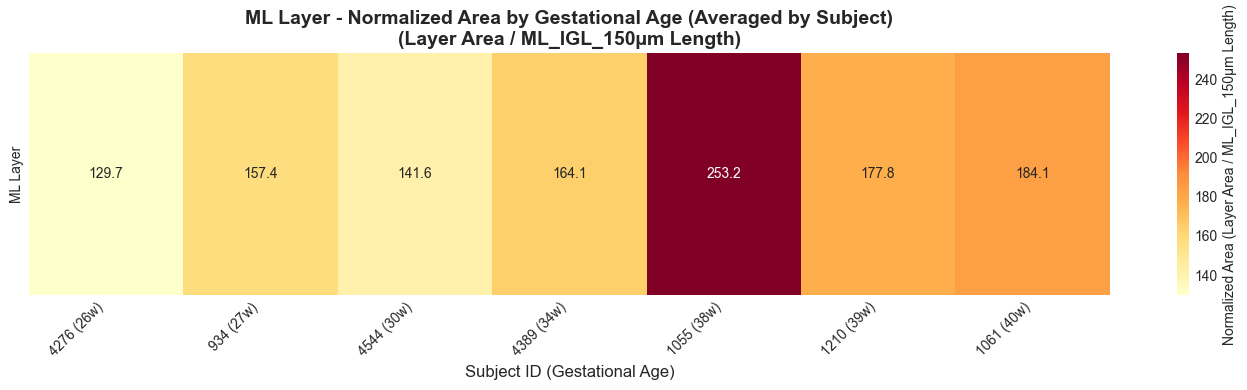


ML Layer Statistics (Averaged by Subject):
Subjects: 7
Mean: 172.54
Std: 40.35
Range: 129.67 - 253.22


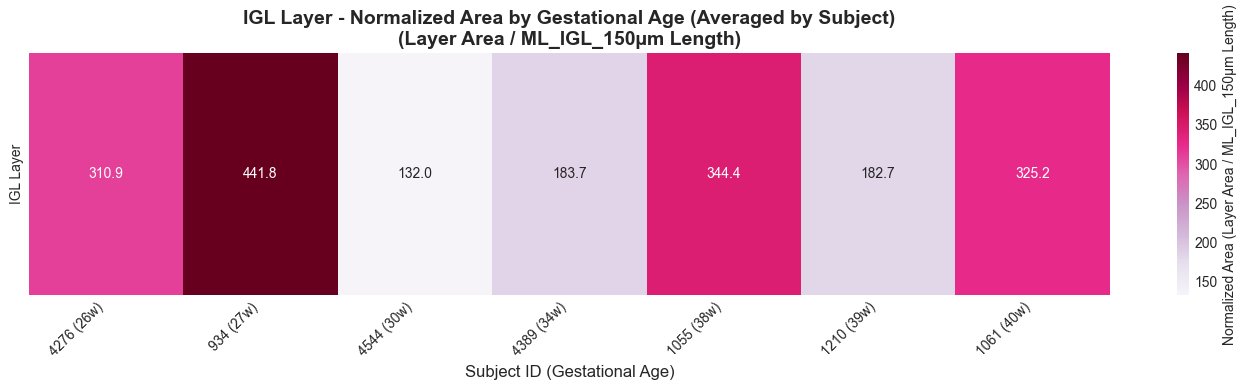


IGL Layer Statistics (Averaged by Subject):
Subjects: 7
Mean: 274.40
Std: 110.86
Range: 132.05 - 441.78


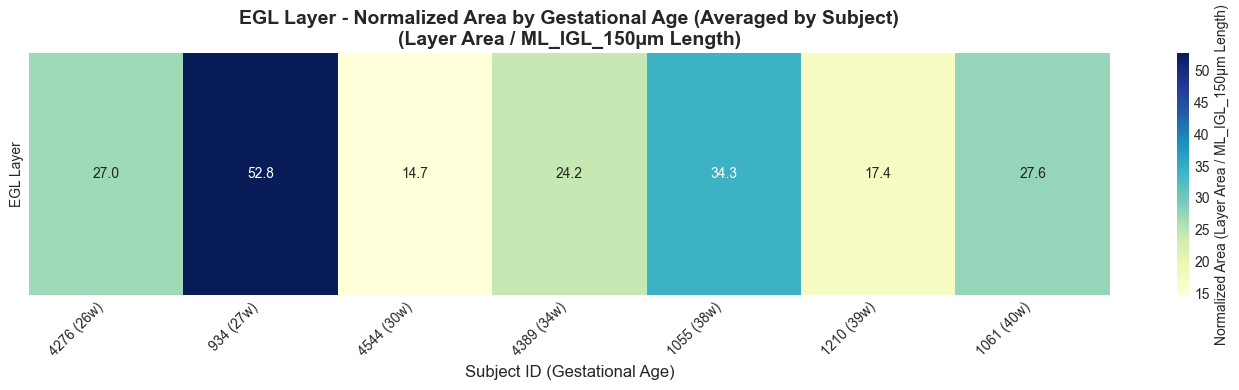


EGL Layer Statistics (Averaged by Subject):
Subjects: 7
Mean: 28.28
Std: 12.64
Range: 14.68 - 52.77


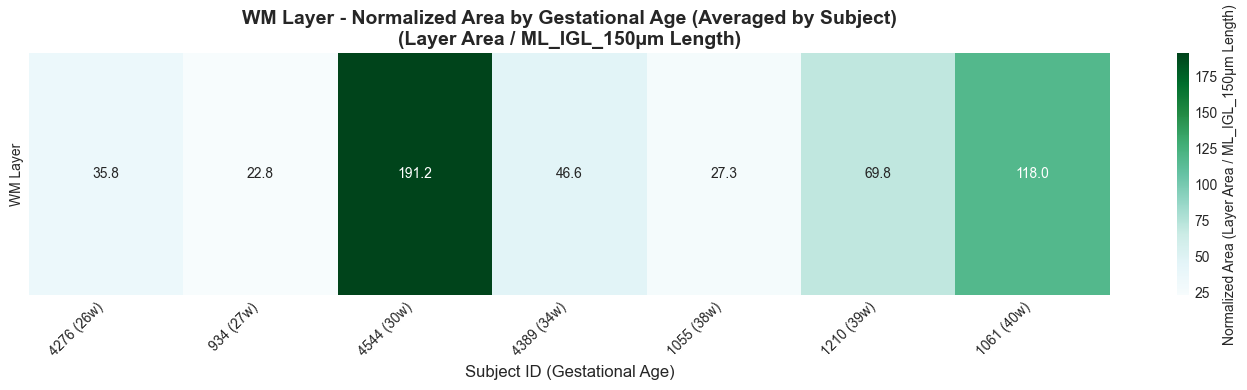


WM Layer Statistics (Averaged by Subject):
Subjects: 7
Mean: 73.07
Std: 61.50
Range: 22.80 - 191.21


In [15]:
# Define color schemes for each layer
color_schemes = {
    'ML': 'YlOrRd',     # Yellow to Orange to Red
    'IGL': 'PuRd',      # Purple to Red
    'EGL': 'YlGnBu',    # Yellow to Green to Blue
    'WM': 'BuGn'        # Blue to Green
}

# Create individual heatmaps for each layer
for layer in layers:
    if f'{layer}_Normalized' not in combined_df.columns:
        print(f"\nSkipping {layer} - no data available")
        continue
    
    # Prepare data for heatmap - using ID instead of Sample
    heatmap_data = combined_df[['ID', 'GA_weeks', f'{layer}_Normalized']].dropna()
    
    if len(heatmap_data) == 0:
        print(f"\nNo data available for {layer} layer")
        continue
    
    # Create ID labels with GA information
    heatmap_data['ID_GA'] = heatmap_data['ID'] + ' (' + heatmap_data['GA_weeks'].astype(str) + 'w)'
    
    # Pivot for heatmap format
    heatmap_matrix = heatmap_data.set_index('ID_GA')[[f'{layer}_Normalized']].T
    
    # Create figure
    plt.figure(figsize=(14, 4))
    
    # Create heatmap
    sns.heatmap(heatmap_matrix,
                cmap=color_schemes[layer],
                annot=True,
                fmt='.1f',
                cbar_kws={'label': f'Normalized Area (Layer Area / ML_IGL_150µm Length)'},
                xticklabels=True,
                yticklabels=[f'{layer} Layer'])
    
    # Customize plot
    plt.title(f'{layer} Layer - Normalized Area by Gestational Age (Averaged by Subject)\n(Layer Area / ML_IGL_150µm Length)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Subject ID (Gestational Age)', fontsize=12)
    plt.ylabel('')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()
    
    # Print statistics
    print(f"\n{layer} Layer Statistics (Averaged by Subject):")
    print(f"Subjects: {len(heatmap_data)}")
    print(f"Mean: {heatmap_data[f'{layer}_Normalized'].mean():.2f}")
    print(f"Std: {heatmap_data[f'{layer}_Normalized'].std():.2f}")
    print(f"Range: {heatmap_data[f'{layer}_Normalized'].min():.2f} - {heatmap_data[f'{layer}_Normalized'].max():.2f}")


## 7. Create Combined Heatmap (All Layers)

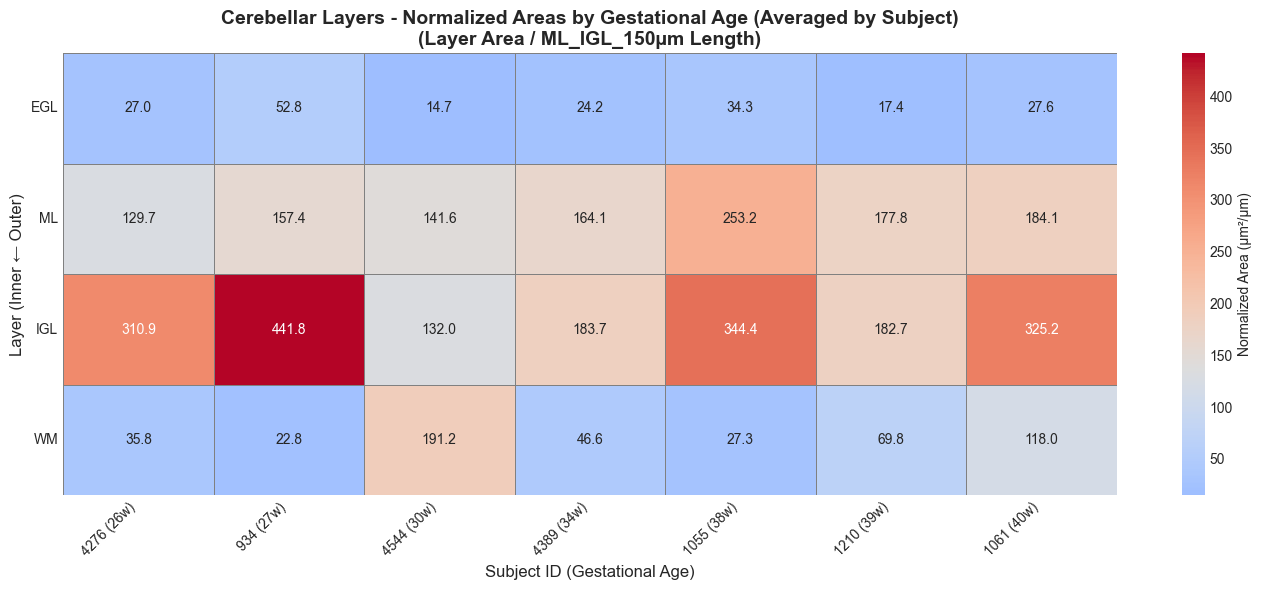

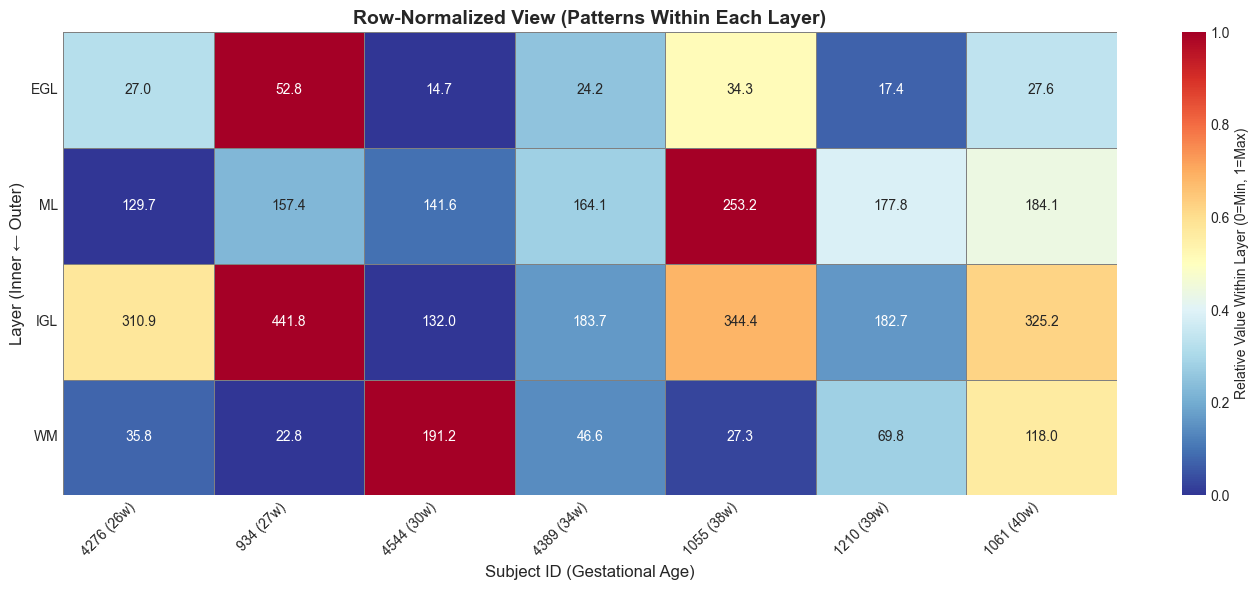


Layer Statistics (from outer to inner, averaged by subject):

EGL (External Granular Layer (Outermost))
  Mean: 28.28 µm²/µm
  Range: 14.68 - 52.77 µm²/µm
  CV: 44.7%

ML (Molecular Layer)
  Mean: 172.54 µm²/µm
  Range: 129.67 - 253.22 µm²/µm
  CV: 23.4%

IGL (Internal Granular Layer)
  Mean: 274.40 µm²/µm
  Range: 132.05 - 441.78 µm²/µm
  CV: 40.4%

WM (White Matter (Innermost))
  Mean: 73.07 µm²/µm
  Range: 22.80 - 191.21 µm²/µm
  CV: 84.2%


In [14]:
# Prepare data for combined heatmap with anatomical ordering
heatmap_combined = pd.DataFrame()

# Define anatomical order from outer to inner
anatomical_order = ['EGL', 'ML', 'IGL', 'WM']

for layer in anatomical_order:
    col_name = f'{layer}_Normalized'
    if col_name in combined_df.columns:
        layer_data = combined_df[['ID', 'GA_weeks', col_name]].dropna()
        layer_data['Layer'] = layer
        layer_data['Value'] = layer_data[col_name]
        layer_data['ID_GA'] = layer_data['ID'] + ' (' + layer_data['GA_weeks'].astype(str) + 'w)'
        heatmap_combined = pd.concat([heatmap_combined, layer_data[['ID_GA', 'Layer', 'Value', 'GA_weeks']]])

# Pivot for heatmap
if not heatmap_combined.empty:
    # Sort by GA weeks
    id_order = heatmap_combined.sort_values('GA_weeks')['ID_GA'].unique()
    
    heatmap_pivot = heatmap_combined.pivot(index='Layer', columns='ID_GA', values='Value')
    
    # Reorder rows by anatomical sequence and columns by GA
    available_layers = [layer for layer in anatomical_order if layer in heatmap_pivot.index]
    heatmap_pivot = heatmap_pivot.loc[available_layers, id_order]
    
    # Normalize each layer separately for better visualization
    heatmap_normalized = heatmap_pivot.copy()
    for layer in heatmap_normalized.index:
        row_values = heatmap_normalized.loc[layer]
        row_min = row_values.min()
        row_max = row_values.max()
        if row_max > row_min:
            heatmap_normalized.loc[layer] = (row_values - row_min) / (row_max - row_min)
    
    # First plot: Actual values
    plt.figure(figsize=(14, 6))
    
    sns.heatmap(heatmap_pivot,
                cmap='coolwarm',
                annot=True,
                fmt='.1f',
                cbar_kws={'label': 'Normalized Area (µm²/µm)'},
                linewidths=0.5,
                linecolor='gray',
                center=heatmap_pivot.mean().mean())
    
    plt.title('Cerebellar Layers - Normalized Areas by Gestational Age (Averaged by Subject)\n(Layer Area / ML_IGL_150µm Length)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Subject ID (Gestational Age)', fontsize=12)
    plt.ylabel('Layer (Inner ← Outer)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # Keep simple layer labels
    plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Second plot: Row-normalized view
    plt.figure(figsize=(14, 6))
    
    sns.heatmap(heatmap_normalized,
                cmap='RdYlBu_r',
                annot=heatmap_pivot.values,  # Show original values
                fmt='.1f',
                cbar_kws={'label': 'Relative Value Within Layer (0=Min, 1=Max)'},
                linewidths=0.5,
                linecolor='gray')
    
    plt.title('Row-Normalized View (Patterns Within Each Layer)', fontsize=14, fontweight='bold')
    plt.xlabel('Subject ID (Gestational Age)', fontsize=12)
    plt.ylabel('Layer (Inner ← Outer)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # Keep simple layer labels
    plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Print layer statistics for context
    print("\nLayer Statistics (from outer to inner, averaged by subject):")
    layer_descriptions = {
        'EGL': 'External Granular Layer (Outermost)',
        'ML': 'Molecular Layer',
        'IGL': 'Internal Granular Layer',
        'WM': 'White Matter (Innermost)'
    }
    for layer in available_layers:
        values = heatmap_pivot.loc[layer]
        print(f"\n{layer} ({layer_descriptions.get(layer, '')})")
        print(f"  Mean: {values.mean():.2f} µm²/µm")
        print(f"  Range: {values.min():.2f} - {values.max():.2f} µm²/µm")
        print(f"  CV: {(values.std() / values.mean() * 100):.1f}%")

## 8. Statistical Analysis and Trends

Analyzing trends across gestational ages...

Testing for normality (Shapiro-Wilk test):
EGL: W=0.898, p=0.320 (Normal)
ML: W=0.881, p=0.229 (Normal)
IGL: W=0.931, p=0.558 (Normal)
WM: W=0.830, p=0.079 (Normal)

Correlation Analysis (Pearson vs Spearman):

EGL Layer:
  Pearson:  r=-0.320, p=0.484
  Spearman: ρ=-0.071, p=0.879

ML Layer:
  Pearson:  r=0.703, p=0.078
  Spearman: ρ=0.857, p=0.014

IGL Layer:
  Pearson:  r=-0.198, p=0.670
  Spearman: ρ=-0.071, p=0.879

WM Layer:
  Pearson:  r=0.115, p=0.806
  Spearman: ρ=0.429, p=0.337


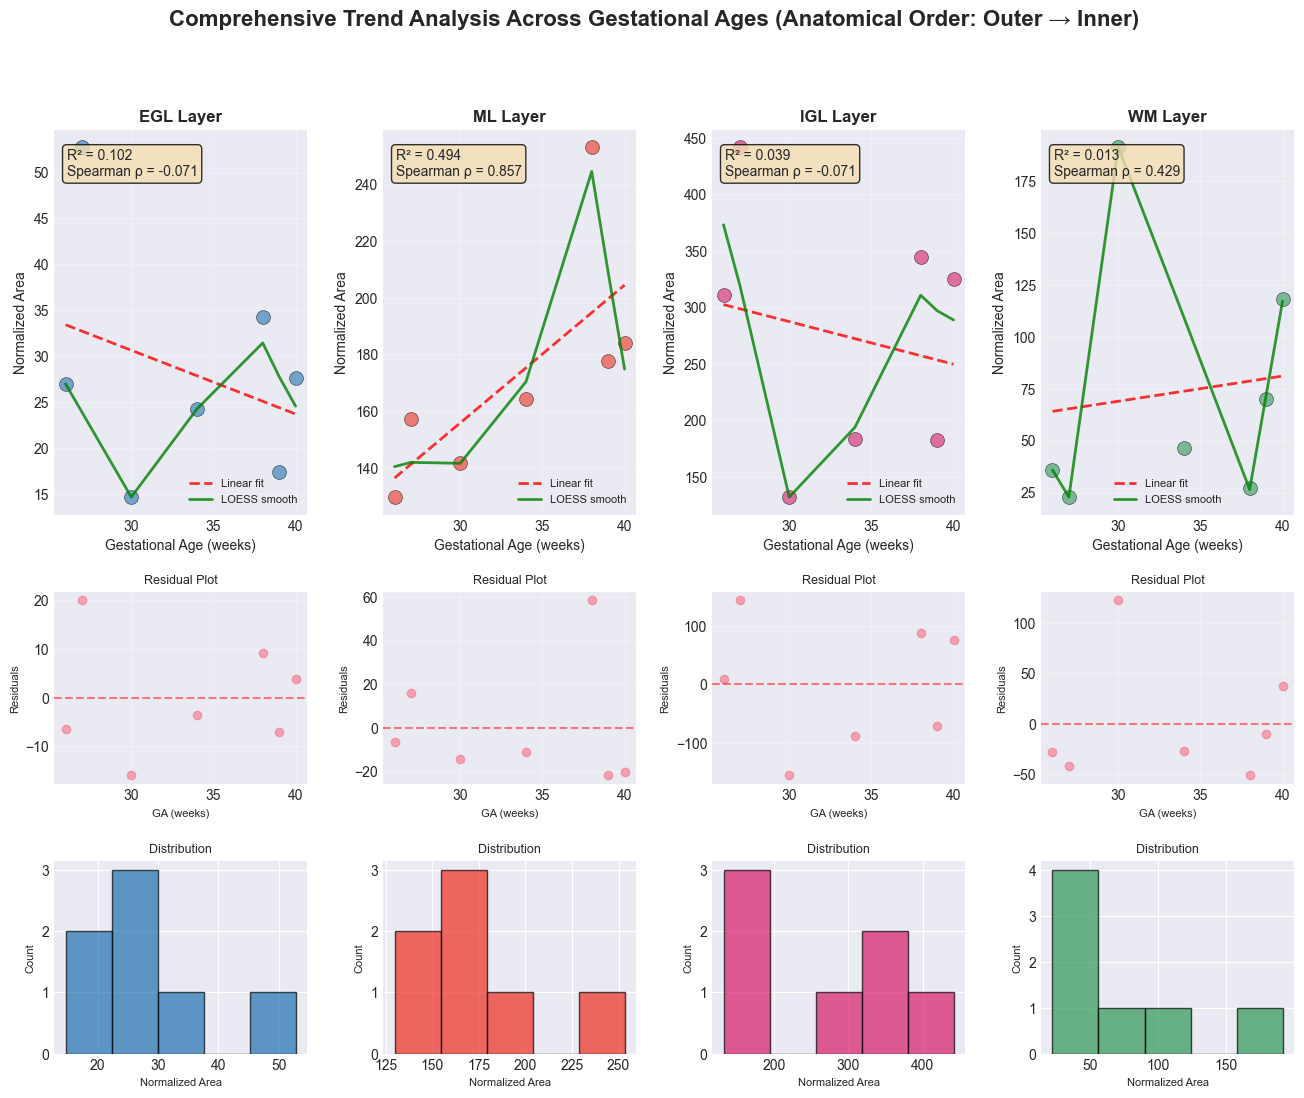


Mann-Kendall Trend Test (for monotonic trends):
EGL: S=-1.0, Z=0.000, p=1.000 - decreasing
ML: S=15.0, Z=2.103, p=0.035 - increasing
IGL: S=-1.0, Z=0.000, p=1.000 - decreasing
WM: S=7.0, Z=0.901, p=0.368 - increasing

Interpretation Guide:
- Shapiro-Wilk: p>0.05 suggests normal distribution
- Correlations: Use Spearman if data is not normally distributed
- Mann-Kendall: Tests for monotonic trends without assuming linearity
- LOESS: Shows potential non-linear patterns in the data
- Layer Order: EGL (outermost) → ML → IGL → WM (innermost)


In [17]:
# Analyze trends across gestational ages
print("Analyzing trends across gestational ages...\n")

# First, let's check the distribution of our data
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Use anatomical order for all analyses
anatomical_order = ['EGL', 'ML', 'IGL', 'WM']  # Outer to Inner

# Check normality for each layer
print("Testing for normality (Shapiro-Wilk test):")
for layer in anatomical_order:
    col_name = f'{layer}_Normalized'
    if col_name in combined_df.columns:
        data = combined_df[col_name].dropna()
        if len(data) >= 3:  # Shapiro-Wilk requires at least 3 samples
            statistic, p_value = stats.shapiro(data)
            print(f"{layer}: W={statistic:.3f}, p={p_value:.3f} {'(Normal)' if p_value > 0.05 else '(Not Normal)'}")

# Calculate both Pearson and Spearman correlations
print("\n" + "="*60)
print("Correlation Analysis (Pearson vs Spearman):")
print("="*60)

for layer in anatomical_order:
    col_name = f'{layer}_Normalized'
    if col_name in combined_df.columns:
        data = combined_df[['GA_weeks', col_name]].dropna()
        if len(data) >= 3:
            # Pearson correlation (assumes linear relationship and normal distribution)
            pearson_r, pearson_p = stats.pearsonr(data['GA_weeks'], data[col_name])
            
            # Spearman correlation (non-parametric, doesn't assume normality)
            spearman_r, spearman_p = stats.spearmanr(data['GA_weeks'], data[col_name])
            
            print(f"\n{layer} Layer:")
            print(f"  Pearson:  r={pearson_r:.3f}, p={pearson_p:.3f}")
            print(f"  Spearman: ρ={spearman_r:.3f}, p={spearman_p:.3f}")

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# Create a 3x4 grid: 4 scatter plots, 4 residual plots, 4 distribution plots
gs = fig.add_gridspec(3, 4, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.3)

for i, layer in enumerate(anatomical_order):
    col_name = f'{layer}_Normalized'
    if col_name in combined_df.columns:
        plot_data = combined_df[['GA_weeks', col_name]].dropna()
        
        if len(plot_data) > 2:
            # Main scatter plot with both linear and LOESS smoothing
            ax_main = fig.add_subplot(gs[0, i])
            
            # Scatter plot
            ax_main.scatter(plot_data['GA_weeks'], plot_data[col_name],
                          s=100, alpha=0.6, color=plt.cm.get_cmap(color_schemes[layer])(0.7),
                          edgecolors='black', linewidth=0.5)
            
            # Linear trend line
            z = np.polyfit(plot_data['GA_weeks'], plot_data[col_name], 1)
            p = np.poly1d(z)
            ax_main.plot(plot_data['GA_weeks'], p(plot_data['GA_weeks']),
                        'r--', alpha=0.8, linewidth=2, label='Linear fit')
            
            # Add LOESS smoothing for non-linear trends
            from statsmodels.nonparametric.smoothers_lowess import lowess
            if len(plot_data) >= 5:  # LOESS needs sufficient points
                smoothed = lowess(plot_data[col_name], plot_data['GA_weeks'], 
                                frac=0.6, it=3, return_sorted=True)
                ax_main.plot(smoothed[:, 0], smoothed[:, 1], 'g-', alpha=0.8, 
                           linewidth=2, label='LOESS smooth')
            
            # Calculate R² and add statistics
            r2 = r2_score(plot_data[col_name], p(plot_data['GA_weeks']))
            spearman_r, _ = stats.spearmanr(plot_data['GA_weeks'], plot_data[col_name])
            
            # Add text box with statistics
            textstr = f'R² = {r2:.3f}\nSpearman ρ = {spearman_r:.3f}'
            ax_main.text(0.05, 0.95, textstr, transform=ax_main.transAxes,
                        verticalalignment='top', 
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            ax_main.set_xlabel('Gestational Age (weeks)', fontsize=10)
            ax_main.set_ylabel('Normalized Area', fontsize=10)
            ax_main.set_title(f'{layer} Layer', fontsize=12, fontweight='bold')
            ax_main.grid(True, alpha=0.3)
            ax_main.legend(fontsize=8)
            
            # Residual plot
            ax_resid = fig.add_subplot(gs[1, i])
            residuals = plot_data[col_name] - p(plot_data['GA_weeks'])
            ax_resid.scatter(plot_data['GA_weeks'], residuals, alpha=0.6)
            ax_resid.axhline(y=0, color='r', linestyle='--', alpha=0.5)
            ax_resid.set_xlabel('GA (weeks)', fontsize=8)
            ax_resid.set_ylabel('Residuals', fontsize=8)
            ax_resid.set_title('Residual Plot', fontsize=9)
            ax_resid.grid(True, alpha=0.3)
            
            # Distribution plot
            ax_dist = fig.add_subplot(gs[2, i])
            ax_dist.hist(plot_data[col_name], bins=5, alpha=0.7, 
                        color=plt.cm.get_cmap(color_schemes[layer])(0.7),
                        edgecolor='black')
            ax_dist.set_xlabel('Normalized Area', fontsize=8)
            ax_dist.set_ylabel('Count', fontsize=8)
            ax_dist.set_title('Distribution', fontsize=9)

# Add main title
fig.suptitle('Comprehensive Trend Analysis Across Gestational Ages (Anatomical Order: Outer → Inner)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Non-parametric trend test (Mann-Kendall test for monotonic trends)
print("\n" + "="*60)
print("Mann-Kendall Trend Test (for monotonic trends):")
print("="*60)

def mann_kendall_test(x, y):
    """Simple Mann-Kendall test implementation"""
    n = len(x)
    s = 0
    for i in range(n-1):
        for j in range(i+1, n):
            s += np.sign((x[j] - x[i]) * (y[j] - y[i]))
    
    # Calculate variance
    var_s = n * (n - 1) * (2 * n + 5) / 18
    
    # Calculate z-score
    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:
        z = 0
    
    # Two-tailed p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    return s, z, p_value

for layer in anatomical_order:
    col_name = f'{layer}_Normalized'
    if col_name in combined_df.columns:
        data = combined_df[['GA_weeks', col_name]].dropna().sort_values('GA_weeks')
        if len(data) >= 3:
            s, z, p = mann_kendall_test(data['GA_weeks'].values, data[col_name].values)
            trend = "increasing" if s > 0 else "decreasing" if s < 0 else "no trend"
            print(f"{layer}: S={s}, Z={z:.3f}, p={p:.3f} - {trend}")

print("\n" + "="*60)
print("Interpretation Guide:")
print("- Shapiro-Wilk: p>0.05 suggests normal distribution")
print("- Correlations: Use Spearman if data is not normally distributed")
print("- Mann-Kendall: Tests for monotonic trends without assuming linearity")
print("- LOESS: Shows potential non-linear patterns in the data")
print("- Layer Order: EGL (outermost) → ML → IGL → WM (innermost)")
print("="*60)
